# Data Analytics - ML25M 

### Imports

In [13]:
import torch
import time
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from torch.utils.tensorboard import SummaryWriter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
import itertools
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# from tab_transformer_pytorch import TabTransformer
# from pytorch_tabnet.tab_model import TabNetClassifier
# from pytorch_tabular import TabularModel
# from pytorch_tabular.models import CategoryEmbeddingModelConfig
# from pytorch_tabular.config import (
#     DataConfig,
#     OptimizerConfig,
#     TrainerConfig,
# )

def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use. 
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  # slower

fix_random(42)


## Data Acquisition

movies.csv contains the following fields:

* movieId - a unique identifier for each movie.
* title - the title of the movie.
* genres - a pipe-separated list of genres for the movie.

It will be used to get the movie title and the genres.

In [14]:
movies_df = pd.read_csv('./ml-25m/movies.csv')
genres = movies_df['genres'].str.get_dummies(sep='|')
movies_df = pd.concat([movies_df, genres], axis=1)
movies_df.drop('genres', axis=1, inplace=True)
movies_df.head(3)


,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


genome-scores.csv contains the following fields:

* movieId - a unique identifier for each movie.
* tagId - a unique identifier for each tag.
* relevance - a score from 0.0 to 1.0 representing the relevance of the tag to the movie.

Combined with the tags.csv file, this will be used to assign tags and their relevance to each movie.

In [15]:
scores_df = pd.read_csv('./ml-25m/genome-scores.csv')
tags_df = pd.read_csv('./ml-25m/genome-tags.csv')
ratings_df = pd.read_csv('./ml-25m/ratings.csv')

df = movies_df.merge(scores_df, on='movieId')
df = df.merge(tags_df, on='tagId')
df = df.pivot_table(index=['movieId', 'title'], columns='tag', values='relevance', fill_value=0).reset_index().rename_axis(None, axis=1)

# average rating for each movie
# ratings_df = ratings_df.groupby(['movieId'])['rating'].mean().reset_index()
# # round ratings to the nearest 0.5
# ratings_df['rating'] = ratings_df['rating'].apply(lambda x: round(x * 2) / 2)

# # mode rating for each movie
ratings_df = ratings_df.groupby(['movieId'])['rating'].agg(lambda x: x.value_counts().index[0]).reset_index()

df = ratings_df.merge(df, on='movieId')

# movieId and title are not needed for the model
df.drop(['movieId', 'title'], axis=1, inplace=True)

## Data visualization

In [16]:
print(f'Number of samples: {df.shape[0]}')
df.head(3)

Number of samples: 13816


,rating,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,...,world politics,world war i,world war ii,writer's life,writers,writing,wuxia,wwii,zombie,zombies
0,4.0,0.02875,0.02375,0.06250,0.07575,0.14075,0.14675,0.06350,0.20375,0.2020,...,0.04050,0.01425,0.03050,0.035,0.14125,0.05775,0.039,0.02975,0.08475,0.02200
1,3.0,0.04125,0.04050,0.06275,0.08275,0.09100,0.06125,0.06925,0.09600,0.0765,...,0.05250,0.01575,0.01250,0.020,0.12225,0.03275,0.021,0.01100,0.10525,0.01975
2,3.0,0.04675,0.05550,0.02925,0.08700,0.04750,0.04775,0.04600,0.14275,0.0285,...,0.06275,0.01950,0.02225,0.023,0.12200,0.03475,0.017,0.01800,0.09100,0.01775


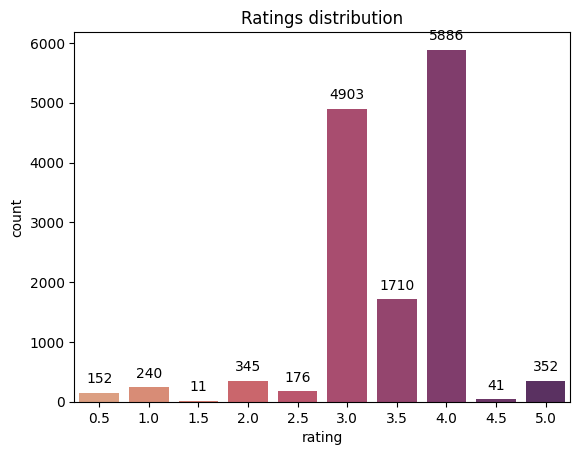

Mode:  0    4.0
Name: rating, dtype: float64
Median: 3.50
Std: 0.73


In [17]:
# Ratings distribution
sns.countplot(x='rating', data=df, palette='flare')
plt.title('Ratings distribution')
for p in plt.gca().patches:
    plt.gca().annotate('{:.0f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

# mean, median, and standard deviation of ratings
print("Mode: ", df['rating'].mode())
print('Median: {:.2f}'.format(df['rating'].median()))
print('Std: {:.2f}'.format(df['rating'].std()))

In [18]:
N_LABELS = df.rating.nunique()
print(f'Number of labels: {N_LABELS}')

# looking for missing values and duplicates
print("Nan: ", df.isna().sum().sum())
print("Duplicates: ", df.duplicated().sum())

Number of labels: 10
Nan:  0
Duplicates:  0


In [19]:
# save the dataframe to a csv file
df.to_csv('./dataset.csv', index=False)

## Data Preprocessing

In [20]:
X = df.drop('rating', axis=1)
Y = df['rating']

# encode Y
Y = LabelEncoder().fit_transform(Y)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Normalization 


# PCA
# pca = PCA(n_components=2)
# pca.fit(X_train)
# X_train = pca.transform(X_train)
# X_test = pca.transform(X_test)

# LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, Y_train)
X_train = lda.transform(X_train)
X_test = lda.transform(X_test)

print(f'Number of training samples: {X_train.shape}')
print(f'Number of testing samples: {X_test.shape}')

results = pd.DataFrame(columns=['Model', 'Accuracy'])

Number of training samples: (11052, 9)
Number of testing samples: (2764, 9)


## Modeling

### Deep Learning for Tabular Data

[PyTorch Tabular](https://github.com/manujosephv/pytorch_tabular#installation)

In [21]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

print(f'Number of training samples: {X_train.shape[0]}')
print(f'Number of validation samples: {X_val.shape[0]}')


Number of training samples: 9946
Number of validation samples: 1106


### TabNet

In [22]:
# Define the TabNet model
tabnet = TabNetClassifier(
    n_d=16, # n_d: the dimensionality of the output space of the feature transformer network (default 64)
    n_a=16, # n_a: the dimensionality of the output space of the attention network (default 64)
    n_steps=4, # n_steps: the number of sequential steps in the attention mechanism (default 3)
    gamma=1.5, # n_steps: the number of sequential steps in the attention mechanism (default 3)
    n_independent=2, # n_independent: the number of independent feature transformer networks to use (default 2)
    n_shared=2, # n_shared: the number of shared feature transformer networks to use (default 2)
    epsilon=1e-15, # epsilon: a small value to add to the denominator of the feature importance calculation to avoid division by zero (default 1e-15)
    seed=42, # seed: the random seed to use for reproducibility (default None)
)

# Train the model
tabnet.fit(
    X_train=X_train,
    y_train=Y_train,
    eval_set=[(X_val, Y_val)],
    patience=10, #patience: the number of epochs to wait without improvement in validation loss before early stopping (default 10)
    batch_size=1024, # batch_size: the number of samples per batch (default 1024)
    virtual_batch_size=128, # virtual_batch_size: the number of samples per virtual batch (default 128)
    num_workers=0, # num_workers: the number of worker processes to use for data loading (default 0)
    drop_last=False, # drop_last: whether to drop the last incomplete batch if the dataset size is not divisible by the batch size (default False)
    max_epochs=100, # max_epochs: the maximum number of epochs to train for (default 100)
)

NameError: name 'TabNetClassifier' is not defined

In [ ]:
# evaluate the model
y_pred = tabnet.predict(X_test)
print(classification_report(Y_test, y_pred))
accuracy = accuracy_score(Y_test, y_pred)


# results = pd.concat([results, pd.DataFrame({'Model': 'TabNet', 'Accuracy': accuracy_score(Y_val, y_pred)}, index=[0])], ignore_index=True)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.36      0.44      0.40         9
           2       0.87      0.72      0.79        80
           3       0.76      0.88      0.82       284
           4       0.89      0.81      0.85       804
           5       0.88      0.89      0.89      1159
           6       0.84      0.88      0.86       426
           7       0.33      1.00      0.50         1

    accuracy                           0.86      2764
   macro avg       0.62      0.70      0.64      2764
weighted avg       0.86      0.86      0.86      2764



### TabTransformer

In [ ]:
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"]="1"

train, test = train_test_split(df, random_state=42)
train, val = train_test_split(train, random_state=42)

In [ ]:
# categorical headers
cat_headers = ['rating']

# numerical headers
num_headers = list(set(df.columns) - set(cat_headers))

data_config = DataConfig(
    target=[
        "rating"
    ],  # target should always be a list. Multi-targets are only supported for regression. Multi-Task Classification is not implemented
    continuous_cols=num_headers,
    categorical_cols=cat_headers,
)
trainer_config = TrainerConfig(
    auto_lr_find=True,  # Runs the LRFinder to automatically derive a learning rate
    batch_size=1024,
    max_epochs=100,
)
optimizer_config = OptimizerConfig()

model_config = CategoryEmbeddingModelConfig(
    task="classification",
    layers="1024-512-512",  # Number of nodes in each layer
    activation="LeakyReLU",  # Activation between each layers
    learning_rate=1e-3,
)

In [ ]:
# Initialize the model
tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)
tabular_model.fit(train=train, validation=val)

2023-03-02 14:26:59,618 - {pytorch_tabular.tabular_model:102} - INFO - Experiment Tracking is turned off
Global seed set to 42
2023-03-02 14:26:59,686 - {pytorch_tabular.tabular_model:465} - INFO - Preparing the DataLoaders
2023-03-02 14:26:59,700 - {pytorch_tabular.tabular_datamodule:286} - INFO - Setting up the datamodule for classification task
2023-03-02 14:27:00,708 - {pytorch_tabular.tabular_model:508} - INFO - Preparing the Model: CategoryEmbeddingModel
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabular/models/base_model.py:132: UserWarning: Plotly is not installed. Please install plotly to log logits. You can install plotly using pip install plotly or install PyTorch Tabular using pip install pytorch-tabular[all]
  warnings.warn(
2023-03-02 14:27:00,857 - {pytorch_tabular.tabular_model:264} - INFO - Preparing the Trainer
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU

NotImplementedError: The operator 'aten::_unique2' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

In [ ]:
# evaluate the model
result = tabular_model.evaluate([X_val,Y_val])
pred_df = tabular_model.predict(X_test)
tabular_model.save_model("tabTransformer/model")
loaded_model = TabularModel.load_from_checkpoint("tabTransformer/model")

## Evaluation